In [3]:
# %matplotlib inline
from skimage import color, data, restoration
import scipy.fftpack as fp
from skimage.measure import compare_psnr
from skimage.io import imread
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.io import imread

from raw_process import *
import glob

def convolve2d(im, psf, k):
    M, N = im.shape
    freq = fp.fft2(im)
    psf = np.pad(psf, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant') # assumption: min(M,N) > k > 0, k odd
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq*freq_kernel))


path2raw= ../data/resChartSZ_ev0.raw


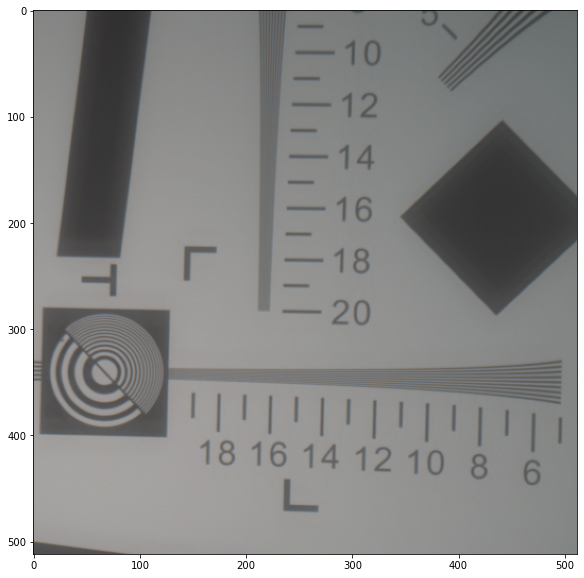

In [55]:
# path2raw = glob.glob('../data/IMG20210119153747_3280x2464_21329_exp_1000000_iso_100_longSide.raw')[0]
# path2raw = glob.glob('../data/IMG20210119153258_3280x2464_21321_exp_1000000_iso_100_shortSide.raw')[0]
path2raw = glob.glob('../data/resChartSZ_ev0.raw')[0]

print("path2raw=", path2raw)
# Load raw and convert to 4ch
raw4ch = raw_to_numpy_float(path2raw, w=3280, h=2464, bl=63, wl=1023)

size = 512
yc, xc = 500, 1000
raw4ch = raw4ch[yc-int(size/2):yc+int(size/2), xc-int(size/2):xc+int(size/2), :]

rgb = raw_to_rgb(raw4ch, neutral=[0.5, 1, 0.4], gamma=2.2, channels=4)
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(rgb)
plt.show()

(512, 512, 4)


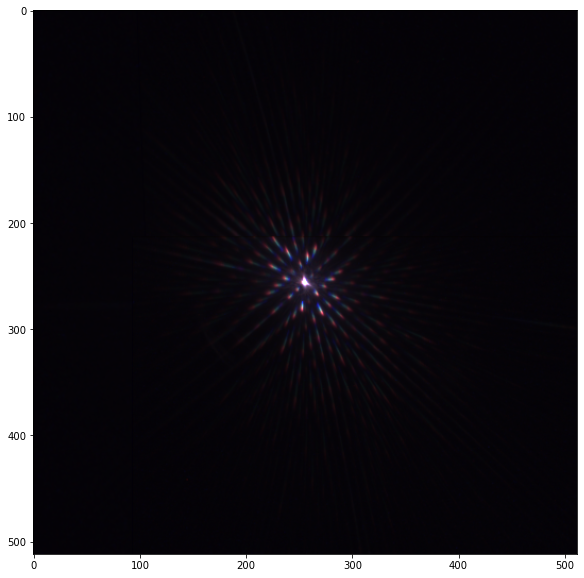

In [58]:
# Prepare PSF, same size as the raw
# path2psf = "../data/ix3_iy3.npy"
path2psf = "../data/ix0_iy0.npy"

psf = np.load(path2psf)
psf512 = psf[int(size/2):-int(size/2), int(size/2):-int(size/2), :]
print(psf512.shape)

coeff = 1e2
rgb_psf512 = raw_to_rgb(psf512*coeff, neutral=[0.5, 1, 0.4], gamma=2.2, channels=4)
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(rgb_psf512)
plt.show()

elapsed_time= 0.05406785011291504


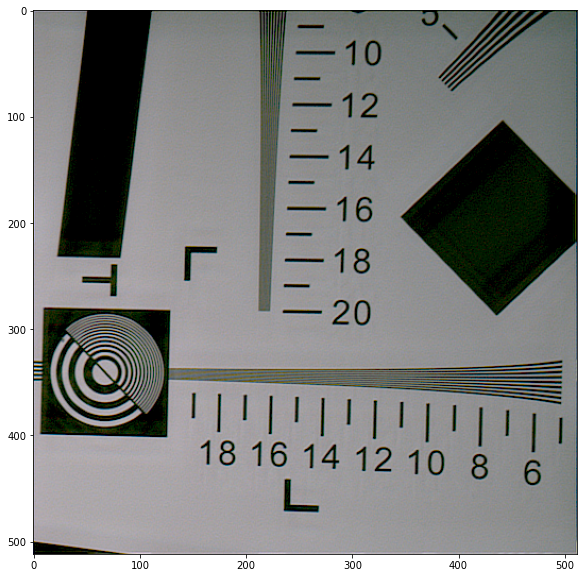

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [59]:
import time
from skimage.restoration import wiener, unsupervised_wiener

wf_raw4ch = np.zeros_like(raw4ch)
balance = 0.001
start_time = time.time()
for c in range(4):
    raw1ch = raw4ch[:,:,c]
    psf1ch = psf512[:,:,c]
    # print("np.sum(psf1ch)=", np.sum(psf1ch))
    psf1ch = psf1ch/np.sum(psf1ch)
    # print("np.sum(psf1ch)=", np.sum(psf1ch))
    wf_raw4ch[:,:,c] = wiener(raw1ch, psf1ch, balance=balance)

elapsed_time = time.time() - start_time
print("elapsed_time=", elapsed_time)

wf_rgb = raw_to_rgb(wf_raw4ch, neutral=[0.5, 1, 0.4], gamma=2.2, channels=4)
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(wf_rgb)
plt.show()

import imageio
imageio.imwrite("../data/szChart_before_after_wiener_filter_{}_balance{}.png".format(os.path.basename(path2psf)[:-4], balance), np.hstack((rgb, wf_rgb)))